In [1]:
from __future__ import print_function

import numpy as np

import tensorflow as tf
from autoencoder import model
import pickle

import os

In [2]:
DEBUG = False
PLOTTING_SUPPORT = True
RUN_AS_PY_SCRIPT = False
SET_EULER_PARAMS = False
SET_MARMOT_PARAMS = False

# Handle arguments (When executed as .py script)
import sys
argv = sys.argv[:]
if len(argv) > 1:
  script_path = argv.pop(0)
  if "--euler" in argv:
    import sys
    sys.stdout = open('stdout.txt', 'w')
    RUN_AS_PY_SCRIPT = True
    PLOTTING_SUPPORT = False
    SET_EULER_PARAMS = True
    print("Parameters set for execution on euler cluster")
    argv.remove("--euler")
  if "--marmot" in argv:
    RUN_AS_PY_SCRIPT = True
    PLOTTING_SUPPORT = False
    SET_MARMOT_PARAMS = True
    print("Parameters set for execution on marmot cluster")
    argv.remove("--marmot") 
  if "--script" in argv:
    RUN_AS_PY_SCRIPT = True
    PLOTTING_SUPPORT = False
    print("Running as script")
    argv.remove("--script") 

In [3]:
if not RUN_AS_PY_SCRIPT:
  %load_ext autoreload
  %autoreload 2
  from IPython.display import clear_output
  if PLOTTING_SUPPORT:
    %matplotlib notebook
    from matplotlib import pyplot as plt

## Parameters

In [4]:
BATCH_SIZE = 10
VOXEL_SIDE = 24

MAX_STEPS = 10000
VAL_EXAMPLES = 200
N_ROTATION_ANGLES = 12
ROTATION_OFFSET = 0
VAL_EVERY_N_STEPS = 1
VAL_STEP_TOLERANCE = 3
TRAIN_TWINS = False

MP = model.ModelParams()
MP.INPUT_SHAPE = [VOXEL_SIDE, VOXEL_SIDE, VOXEL_SIDE, 1]

HOME_DIR = os.path.expanduser('~')
DATA_DIR = "./database/"
RUN_NAME = "kitti18"
RESTORE_MODEL = True
SAVE_DIR = HOME_DIR + "/Desktop/autoencoder/"
SAVE_FILE = "model.checkpoint"
MP_FILENAME = "model_params.pckl"
TENSORBOARD_DIR = HOME_DIR + "/tensorboard"
SAVE_UNVALIDATED = False
CREATE_VISUALS = False
DETAILED_STEP_TIMES = False

EXPORT_FEATURES = False

In [5]:
if SET_EULER_PARAMS:
    DATA_DIR = "/cluster/home/dugasd/database/"
    SAVE_DIR = "/cluster/home/dugasd/autoencoder-euler/"
    TENSORBOARD_DIR = None
    CREATE_VISUALS = False
    
    MAX_STEPS = 1000000
    VAL_STEP_TOLERANCE = 5
    
if SET_MARMOT_PARAMS:
    DATA_DIR = "/home/daniel/database/"
    RUN_NAME = "kitti18-20-27"
    SAVE_DIR = "/home/daniel/autoencoder-marmot/"
    TENSORBOARD_DIR = None
    CREATE_VISUALS = False
    
    MAX_STEPS = 1000000
    VAL_STEP_TOLERANCE = 10
    N_ROTATION_ANGLES = 36
    
if not RUN_AS_PY_SCRIPT:
    #MP.CONVOLUTION_LAYERS = [{'type': 'conv3d', 'filter': [5, 5, 5,  1, 10], 'downsampling': {'type': 'max_pool3d', 'k': 2}}]
    MP.CONVOLUTION_LAYERS = []
    #MP.LATENT_SHAPE = [2]
    N_ROTATION_ANGLES = 6
    CREATE_VISUALS = True

In [6]:
if RUN_AS_PY_SCRIPT:
  while argv:
      arg = argv.pop(0)
      if arg == "-RUN_NAME":
        RUN_NAME = argv.pop(0)
        print("RUN_NAME set to " + RUN_NAME)
      elif arg == "-SAVE_DIR":
        SAVE_DIR = argv.pop(0)
        print("SAVE_DIR set to " + SAVE_DIR)
      elif arg == "--noconv":
        MP.CONVOLUTION_LAYERS = []
        print("CONVOLUTION LAYERS REMOVED")
      elif arg == "--twins":
        TRAIN_TWINS = True
        print("Training twins.")
      elif arg == "-LATENT_SHAPE":
        MP.LATENT_SHAPE = [int(argv.pop(0))]
        print("LATENT_SHAPE set to " + str(MP.LATENT_SHAPE))
      elif arg == "-CLIP_GRADIENTS":
        MP.CLIP_GRADIENTS = float(argv.pop(0))
        print("CLIP_GRADIENTS set to " + str(MP.CLIP_GRADIENTS))
      elif arg == "-N_ROTATION_ANGLES":
        N_ROTATION_ANGLES = int(argv.pop(0))
        print("N_ROTATION_ANGLES set to " + str(N_ROTATION_ANGLES))
      elif arg == "-ROTATION_OFFSET":
        frac = list(map(float, argv.pop(0).split('/'))) + [1.0]
        ROTATION_OFFSET = frac[0]/frac[1]
        print("ROTATION_OFFSET set to " + str(ROTATION_OFFSET))
      elif arg == "--float64":
        MP.FLOAT_TYPE = tf.float64
        print("MP.FLOAT_TYPE set to " + str(MP.FLOAT_TYPE))
      else:
        print("Unknown argument: " + arg)

In [7]:
SAVE_PATH = SAVE_DIR+SAVE_FILE
if SAVE_UNVALIDATED:
  SAVE_DIR_NOVAL = SAVE_DIR+"unvalidated/"
  SAVE_PATH_NOVAL = SAVE_DIR_NOVAL+SAVE_FILE

## Load Segments and Features

In [8]:
import utilities
run_names, runs = utilities.list_runs(DATA_DIR)
try:
  run_names.remove(RUN_NAME)
  run_names = [RUN_NAME] + run_names
except:
  print(RUN_NAME + " not found in runs.")
print(run_names)

['kitti18']


In [9]:
if not RUN_AS_PY_SCRIPT:
  from ipywidgets import widgets
  run_dropdown = widgets.Dropdown(description="Run to import : ", options=run_names)
  button = widgets.Button(description="import")

  # Interaction functions
  def import_run_data(btn):
    display.clear_output()
    print("Loading segments, features, matches, classes for run")
    global segments, features, fnames, matches, classes, ids, classes_set # 'output' variables
    segments, features, fnames, matches, classes, ids = utilities.import_run(run_dropdown.value, folder=DATA_DIR)
    classes_set = sorted(list(set(classes)))
  
  button.on_click(import_run_data)
  # Display widgets
  from IPython import display
  display.display(run_dropdown)
  display.display(button)

  import_run_data(button)
else:
  segments, features, fnames, matches, classes, ids = utilities.import_run(RUN_NAME, folder=DATA_DIR)
  classes_set = sorted(list(set(classes)))

Loading segments, features, matches, classes for run
  Found 1187 segments
  Found features for 1187 segments 
  Found 56 groups of matches
  Found 1187 segment ids
  Found classes for 1187 segments


## Create Autoencoder

In [10]:
if not RUN_AS_PY_SCRIPT:
  try:
    stored_MP = pickle.load(open(SAVE_DIR+MP_FILENAME, 'rb'))
    if MP != stored_MP: 
        print("WARNING: Setting params for compatibility with stored model.")
        print("Stored model: "); print(stored_MP); print("New model: "); print(MP)
    MP = stored_MP
  except FileNotFoundError:
    print("No stored model found. Creating a new model.")

In [25]:
vae = model.Autoencoder(MP)
if TRAIN_TWINS: vae.build_twin_graph()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [12]:
if TENSORBOARD_DIR != None:
  summary_writer = tf.train.SummaryWriter(TENSORBOARD_DIR, vae.sess.graph)

In [13]:
if RESTORE_MODEL:
  try:
    vae.saver.restore(vae.sess, SAVE_PATH)
    print("Model restored.")
    print(MP.CONVOLUTION_LAYERS)
  except:
    print("Could not load model: ", end="")
    try:
      stored_MP = pickle.load(open(SAVE_DIR+MP_FILENAME, 'rb'))
      print("ERROR: mismatch between model params.")
      print("Stored model: "); print(stored_MP); print("New model: "); print(MP)
    except:
      print("no model folder.")

Model restored.
[]


## Create Voxelized Segment Dataset - With Rotated Copies

In [19]:
## Split into training and val data
split_at = min(VAL_EXAMPLES, int(0.2 * len(ids)))
val = segments[:split_at]
train = segments[split_at:]

In [20]:
if not TRAIN_TWINS:
  print("Rotating segments")
  from voxelize import create_rotations
  train = create_rotations(train, N_ROTATION_ANGLES, ROTATION_OFFSET)
  val = create_rotations(val, 12, ROTATION_OFFSET)

  print("Voxelizing training data")
  from voxelize import voxelize
  train_vox, _ = voxelize(train,VOXEL_SIDE)
  val_vox, _   = voxelize(val  ,VOXEL_SIDE)

  if train_vox[0].shape != MP.INPUT_SHAPE:
    print("Reshaping")
    train_vox=[np.reshape(vox, MP.INPUT_SHAPE) for vox in train_vox]
    val_vox=[np.reshape(vox, MP.INPUT_SHAPE) for vox in val_vox]

  del train # Save some memory
else:
  from voxelize import create_twins
  val, val_twins = create_twins(val)
  train, train_twins = create_twins(train)

  print("Voxelizing training data")
  from voxelize import voxelize
  train_vox, _ = voxelize(train,VOXEL_SIDE)
  val_vox, _   = voxelize(val ,VOXEL_SIDE)
  train_twins_vox, _ = voxelize(train_twins,VOXEL_SIDE)
  val_twins_vox, _   = voxelize(val_twins  ,VOXEL_SIDE)
 
  del train_twins

Voxelizing training data


In [21]:
import os
import psutil
process = psutil.Process(os.getpid())
print("Using " + str(process.memory_info().rss/(1024.0*1024.0)) + "mB of memory")

Using 894.2890625mB of memory


## Train Autoencoder ( Computationally Intensive )

Previous cost log found.
Voxelizing training data


/home/daniel/Documents/catkin_ws/src/segmatch/segmatch/python/autoencoder/model.py:390: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if twin_input != None:
/home/daniel/Documents/catkin_ws/src/segmatch/segmatch/python/autoencoder/model.py:394: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  cost = self.cost if twin_input == None else self.twin_cost
/home/daniel/Documents/catkin_ws/src/segmatch/segmatch/python/autoencoder/model.py:395: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  opt = self.optimizer if twin_input == None else self.twin_optimizer


<IPython.core.display.Javascript object>


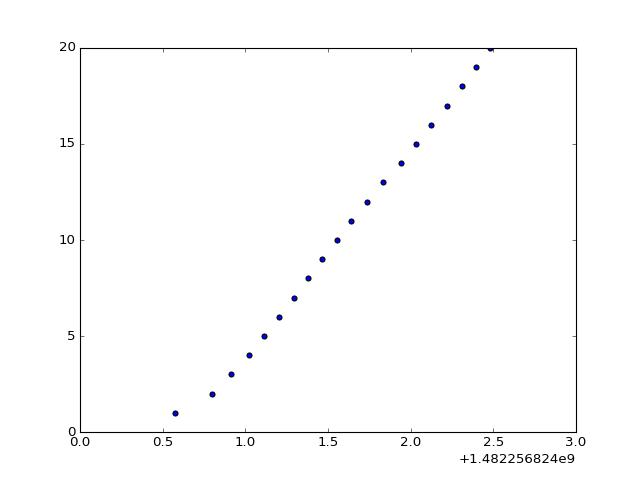

Validation cost: 193550.413086  (Training cost: None) 
Saving ... Model saved in file: /home/daniel/Desktop/autoencoder/model.checkpoint


FailedPreconditionError: Attempting to use uninitialized value Twin_Optimizer_1/beta2_power
	 [[Node: Twin_Optimizer_1/beta2_power/read = Identity[T=DT_FLOAT, _class=["loc:@EncoderLayer0Weights/weights_encoder_0"], _device="/job:localhost/replica:0/task:0/cpu:0"](Twin_Optimizer_1/beta2_power)]]

Caused by op 'Twin_Optimizer_1/beta2_power/read', defined at:
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2831, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-910f5040faff>", line 1, in <module>
    vae.build_twin_graph()
  File "/home/daniel/Documents/catkin_ws/src/segmatch/segmatch/python/autoencoder/model.py", line 370, in build_twin_graph
    self.twin_optimizer = tf.train.AdamOptimizer(learning_rate=self.MP.LEARNING_RATE).minimize(self.twin_cost)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tensorflow/python/training/optimizer.py", line 279, in minimize
    name=name)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tensorflow/python/training/optimizer.py", line 393, in apply_gradients
    self._create_slots(var_list)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tensorflow/python/training/adam.py", line 116, in _create_slots
    trainable=False)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tensorflow/python/ops/variables.py", line 224, in __init__
    expected_shape=expected_shape)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tensorflow/python/ops/variables.py", line 370, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1424, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/daniel/anaconda2/envs/ml3/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Twin_Optimizer_1/beta2_power
	 [[Node: Twin_Optimizer_1/beta2_power/read = Identity[T=DT_FLOAT, _class=["loc:@EncoderLayer0Weights/weights_encoder_0"], _device="/job:localhost/replica:0/task:0/cpu:0"](Twin_Optimizer_1/beta2_power)]]


In [28]:
from timeit import default_timer as timer
from autoencoder.batchmaker import Batchmaker, progress_bar

total_step_cost = None
step_cost_log = []
total_val_cost = 0
val_steps_since_last_improvement = 0
step_start = timer()

try:
    val_cost_log = list(np.loadtxt(SAVE_DIR+"val_cost_log.txt"))
    print("Previous cost log found.")
except:
    val_cost_log = []
    
# single step
for step in range(MAX_STEPS):
  if TRAIN_TWINS:
      val, val_twins = create_twins(val)
      train, train_twins = create_twins(train)
      print("Voxelizing training data")
      from voxelize import voxelize
      train_vox, _ = voxelize(train,VOXEL_SIDE)
      val_vox, _   = voxelize(val ,VOXEL_SIDE)
      train_twins_vox, _ = voxelize(train_twins,VOXEL_SIDE)
      val_twins_vox, _   = voxelize(val_twins  ,VOXEL_SIDE)
      del train_twins
  # Validation
  val_batchmaker = Batchmaker(val_vox, val_twins_vox, BATCH_SIZE, MP)
  if np.mod(step, VAL_EVERY_N_STEPS) == 0:
    total_val_cost = 0
    while True:
      if val_batchmaker.is_depleted():
        break
      else:
        batch_input_values, batch_twin_values = val_batchmaker.next_batch()
        cost_value = vae.cost_on_single_batch(batch_input_values, batch_twin_values)
        total_val_cost += cost_value
        if PLOTTING_SUPPORT:
          progress_bar(val_batchmaker)
    print("Validation cost: "+str(total_val_cost)+"  (Training cost: "+str(total_step_cost)+")", end="")
    try:
      print(" Step Time: " + str(step_end-step_start))
      if DETAILED_STEP_TIMES:
        print(step_times)
    except: 
        print(" ")
    
    val_cost_log.append(total_val_cost)
    
    # Training Monitor
    if len(val_cost_log) > 1:
        # Save cost log.
        import os
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)
            if SAVE_UNVALIDATED: os.makedirs(SAVE_DIR_NOVAL)
            print("Created directory: %s" % SAVE_DIR)
            with open(SAVE_DIR+MP_FILENAME, 'wb') as file:
              pickle.dump(MP, file, protocol=2)
        np.savetxt(SAVE_DIR+"val_cost_log.txt", val_cost_log)
        # Save if cost has improved. Otherwise increment counter.
        if val_cost_log[-1] <  min(val_cost_log[:-1]):
            val_steps_since_last_improvement = 0
            # save model to disk
            print("Saving ... ", end='')
            save_path = vae.saver.save(vae.sess, SAVE_PATH)
            print("Model saved in file: %s" % save_path)      
        else:
            val_steps_since_last_improvement += 1  
    # Stop training if val_cost hasn't improved in VAL_STEP_TOLERANCE steps
    if val_steps_since_last_improvement > VAL_STEP_TOLERANCE:
        if SAVE_UNVALIDATED:
            print("Saving ... ", end='')
            save_path = vae.saver.save(vae.sess, SAVE_PATH_NOVAL)
            print("Unvalidated model saved in file: %s" % save_path)
        print("Training stopped by validation monitor.")
        break
            
  # Train on batches
  step_start = timer()
  zero = timer() - timer()
  step_times = {'batchmaking': zero, 'training': zero, 'plotting': zero}
  total_step_cost = 0
  training_batchmaker = Batchmaker(train_vox, train_twins_vox, BATCH_SIZE, MP)
  while True:
    if training_batchmaker.is_depleted():
      break
    else:
      t_a = timer()  
      batch_input_values, batch_twin_values = training_batchmaker.next_batch()
      t_b = timer()
      # Train over 1 batch.
      cost_value = vae.train_on_single_batch(batch_input_values, batch_twin_values)
      total_step_cost += cost_value
      t_c = timer()
      if PLOTTING_SUPPORT:
        progress_bar(training_batchmaker)
      t_d = timer()
      step_times['batchmaking'] += t_b - t_a
      step_times['training']    += t_c - t_b
      step_times['plotting']    += t_d - t_c
  step_cost_log.append(total_step_cost)
  step_end = timer()


print("Training ended.")

## Visualize Autoencoder Performance

In [ ]:
if PLOTTING_SUPPORT:
  # Plot a few random samples
  import matplotlib.pyplot as plt
  %matplotlib notebook
  plt.ion()
  n_samples = 5
  import random
  x_samples = random.sample(val_vox, 5)
  x_samples = [np.reshape(sample, MP.INPUT_SHAPE) for sample in x_samples]
  x_reconstruct = vae.encode_decode(x_samples)
  plt.figure(figsize=(8, 12))
  for i in range(n_samples):
    plt.subplot(n_samples*2, 1, 2*i + 1)
    plt.imshow(x_samples[i].reshape(VOXEL_SIDE, VOXEL_SIDE*VOXEL_SIDE), vmin=0, vmax=1, cmap='spectral')
    plt.title("Top: val input - Bottom: Reconstruction")
    plt.subplot(n_samples*2, 1, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(VOXEL_SIDE, VOXEL_SIDE*VOXEL_SIDE), vmin=0, vmax=1, cmap='spectral')
  plt.tight_layout()

In [ ]:
if PLOTTING_SUPPORT:
  nx = ny = 4
  nz = 1
  dim1 = 0
  dim2 = 1
  dim3 = 0
  x_values = np.linspace(-3, 3, nx)
  y_values = np.linspace(-3, 3, ny)
  z_values = np.linspace(-3, 3, nz)
  canvas = np.empty((VOXEL_SIDE*ny, VOXEL_SIDE*nx, VOXEL_SIDE*nz))
  for i, yi in enumerate(x_values):
      for j, xi in enumerate(y_values):
          for k, zi in enumerate(z_values):
              # we can only visualize 3 dimensions, in this case the first 3
              latent_sample = np.zeros([1]+MP.LATENT_SHAPE)
              latent_sample.flat[dim1] = xi
              latent_sample.flat[dim2] = yi
              latent_sample.flat[dim3] = zi
              x_mean = vae.decode(latent_sample)
              canvas[(nx-i-1)*VOXEL_SIDE:(nx-i)*VOXEL_SIDE,
                     j*VOXEL_SIDE:(j+1)*VOXEL_SIDE,
                     k*VOXEL_SIDE:(k+1)*VOXEL_SIDE] \
                   = x_mean[0].reshape(VOXEL_SIDE, VOXEL_SIDE, VOXEL_SIDE)
  from mpl_toolkits.mplot3d import Axes3D
  threshold = 0.7
  X,Y,Z = np.where(canvas > (threshold*np.max(canvas)))
  fig = plt.figure()
  plt.cla()
  ax = Axes3D(fig)
  ax.scatter(X, Y, Z)

## Compute Autoencoder Features for Segments

In [ ]:
if not RUN_AS_PY_SCRIPT:
  print("Voxelizing segments")
  from voxelize import voxelize
  segments_vox, features_voxel_scale = voxelize(segments, VOXEL_SIDE)

In [ ]:
if not RUN_AS_PY_SCRIPT:
    print("Computing Eigenvalue Features")
    from eigenvalues import eigenvalue_features
    features_eig = eigenvalue_features(segments)
    features_eig[np.where(np.isnan(features_eig))] = 0
    F = features_eig
    C = classes

In [ ]:
if not RUN_AS_PY_SCRIPT:
  print("Computing Features for Segments")
  features_nn, confusion_nn = vae.batch_encode([np.reshape(sample, MP.INPUT_SHAPE) for sample in segments_vox])
  fnames_nn = ['autoencoder_feature'+str(i+1) for i, _ in enumerate(features_nn[0])]
  F = features_nn
  C = classes

In [ ]:
if not RUN_AS_PY_SCRIPT:
  print("Rotating segments")
  from voxelize import create_rotations
  rotated_segments, rotated_classes = create_rotations(segments, N_ROTATION_ANGLES, classes=classes)
  if False: # walls_vs_cars
    print("Removing unknowns")
    rotated_segments = [segment for segment, class_ in zip(rotated_segments, rotated_classes) if class_ != "unknown"]
    rotated_classes = [class_ for class_ in rotated_classes if class_ != "unknown"]
  print("Voxelizing rotations")
  from voxelize import voxelize
  rotated_segments_vox, rotated_segments_scale = voxelize(rotated_segments, VOXEL_SIDE)
  print("Computing Features for rotations")
  rotated_features, _ = vae.batch_encode([np.reshape(sample, MP.INPUT_SHAPE) for sample in rotated_segments_vox])
  F = rotated_features
  C = rotated_classes

## T-SNE

In [ ]:
if not RUN_AS_PY_SCRIPT:
  print("T-SNE")
  dir_ = "/tmp/online_matcher/visuals/"
  import os
  if not os.path.exists(dir_):
    os.makedirs(dir_)
  if MP.LATENT_SHAPE[0] == 2:
    F2 = F
  else:
    from tools.tsne import tsne
    F2 = tsne(F, err_threshold=1.0)
  from itertools import cycle
  cnames = ['dodgerblue', 'gold', 'silver', 'tomato', 
            'plum', 'lemonchiffon', 'grey', 'orchid', 'lime', 'palegreen']
  from matplotlib import pyplot as plt
  plt.figure(figsize=(12,7))
  for c_, name in zip(cycle(cnames), classes_set):
    x = [values[0] for values, class_ in zip(F2, C) if class_ == name]
    y = [values[1] for values, class_ in zip(F2, C) if class_ == name]
    plt.scatter(x, y, c=c_, alpha=0.8,  lw = 0)
  box = plt.gca().get_position()
  plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ncol = 2 if len(classes_set) > 10 else 1
  plt.legend(classes_set, loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
  plt.title('T-SNE')
  plt.xlabel('x_dim')
  plt.ylabel('y_dim')
  plt.show()
  try:
    plt.gcf().savefig(dir_+"t-sne.png")
  except:
    print("not saved.")
  if len(matches) > 0:
    print("Adding matches")
    # Dim all points
    plt.cla()
    for c_, name in zip(cycle(cnames), classes_set):
      x = [values[0] for values, class_ in zip(F2, C) if class_ == name]
      y = [values[1] for values, class_ in zip(F2, C) if class_ == name]
      plt.scatter(x, y, c=c_, alpha=0.2,  lw = 0)
    plt.legend(classes_set, loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    plt.title('T-SNE')
    plt.xlabel('x_dim')
    plt.ylabel('y_dim')
    # Bring out matched points
    matched_ids = [id_ for match in matches for id_ in match]
    for c_, name in zip(cycle(cnames), classes_set):
      x = [values[0] for values, class_, id_ in zip(F2, C, ids) if class_ == name and id_ in matched_ids]
      y = [values[1] for values, class_, id_ in zip(F2, C, ids) if class_ == name and id_ in matched_ids]
      plt.scatter(x, y, c=c_, s=30, lw = 1)
    # Show matches as lines
    for match in matches:
        line_x = [ F2[ids.index(match[0])][0], F2[ids.index(match[1])][0] ]
        line_y = [ F2[ids.index(match[0])][1], F2[ids.index(match[1])][1] ]
        plt.plot(line_x, line_y, 'black', linewidth=1)
        try:
            plt.gcf().savefig(dir_+"t-sne_matches.png")
        except:
            print("not saved.") 

## Reconstructions

In [ ]:
RC_CONFIDENCE = 0.2
ONEVIEW = True

In [ ]:
# Reconstructions
if not RUN_AS_PY_SCRIPT:
  N = 400
  SV_ = segments_vox[:N]
  S_ = segments[:N]
  I_ = ids[:N]
  reconstruction_vox = vae.batch_encode_decode([np.reshape(sample, MP.INPUT_SHAPE) for sample in SV_])
  reconstruction_vox = [np.reshape(vox, [VOXEL_SIDE, VOXEL_SIDE, VOXEL_SIDE]) for vox in reconstruction_vox]
  from voxelize import unvoxelize
  reconstruction = [unvoxelize(vox > RC_CONFIDENCE) for vox in reconstruction_vox]
  reconstruction = [segment*scale for (segment, scale) in zip(reconstruction, features_voxel_scale)]             
  if CREATE_VISUALS:
    dir_ = "/tmp/online_matcher/visuals/reconstructions/"
    from visuals import visuals_of_matches
    reconstruction_ids = [id_+max(I_)+1 for id_ in I_]
    one_to_one_matches = [[id1, id2] for id1, id2 in zip(I_, reconstruction_ids)]
    visuals_of_matches(one_to_one_matches, S_+reconstruction, I_+reconstruction_ids, directory=dir_, oneview=ONEVIEW)
    clear_output()

In [ ]:
# Reconstructions of rotations for one object
if CREATE_VISUALS:
  dir_ = "/tmp/online_matcher/visuals/rotations/"
  class_name = "car"
  class_ids = [np.random.choice([id_ for id_, class_ in zip(ids, classes) if class_ == class_name])]
  class_indices = [ids.index(id_) for id_ in class_ids]
  class_segments = np.array(segments)[class_indices]
  
  from voxelize import create_rotations
  class_rotated_segments = np.array(list(class_segments) + list(create_rotations(class_segments, N_ROTATION_ANGLES)))
  from voxelize import voxelize
  class_segments_vox, class_voxel_scale = voxelize(class_rotated_segments, VOXEL_SIDE)
  if CREATE_VISUALS:
    class_reconstruction_vox = vae.batch_encode_decode([np.reshape(vox, MP.INPUT_SHAPE) for vox in class_segments_vox])
    class_reconstruction_vox = [np.reshape(vox, [VOXEL_SIDE, VOXEL_SIDE, VOXEL_SIDE]) for vox in class_reconstruction_vox]
    from voxelize import unvoxelize
    class_reconstruction = [unvoxelize(vox > RC_CONFIDENCE) for vox in class_reconstruction_vox]
    class_reconstruction = [segment*scale for (segment, scale) in zip(class_reconstruction, class_voxel_scale)] 
    from visuals import visuals_of_matches
    fake_ids = list(range(len(class_reconstruction)))
    fake_reconstruction_ids = [id_+max(fake_ids)+1 for id_ in fake_ids]
    one_to_one_matches = [[id1, id2] for id1, id2 in zip(fake_ids, fake_reconstruction_ids)]
    visuals_of_matches(one_to_one_matches,
                       list(class_rotated_segments)+class_reconstruction,
                       fake_ids+fake_reconstruction_ids,
                       directory=dir_, oneview=ONEVIEW)
    clear_output()
  class_features, confusion = vae.batch_encode([np.reshape(vox, MP.INPUT_SHAPE) for vox in class_segments_vox])
  class_features = np.array(class_features)
  print(class_name)
  print("Id: "+str(class_ids[0]))
  from matplotlib import pyplot as plt
  plt.figure()
  plt.step(range(len(class_features.T)), class_features.T, color='k', alpha=0.2, where='mid')
  plt.plot(np.sqrt(np.exp(confusion)).T, 'r')
  plt.show()
  plt.gcf().savefig(dir_+"signature.png")

In [ ]:
#Gifs
id_ = np.random.choice(ids)
print(id_)
segment = segments[ids.index(id_)]
import visuals
visuals.single_segment_as_gif(segment)
visuals.single_segment_reconstruction_as_gif(segment, vae, confidence=0.3)
visuals.single_segment_rotations_reconstruction_as_gif(segment, vae, confidence=0.3)
visuals.single_segment_degeneration_as_gif(segment, vae, confidence=0.3)
visuals.single_segment_confidence_as_gif(segment, vae)

## Class Signatures

In [ ]:
if PLOTTING_SUPPORT:
  dir_ = "/tmp/online_matcher/visuals/reconstructions/"
  for class_name in classes_set:
    print(class_name)
    class_ids = [id_ for id_, class_ in zip(ids, classes) if class_ == class_name]
    class_indices = [ids.index(id_) for id_ in class_ids]
    class_segments = np.array(segments)[class_indices]
    class_features = np.array(features_nn)[class_indices]
    class_confusion = np.array(confusion_nn)[class_indices]
    from matplotlib import pyplot as plt
    plt.figure()
    plt.step(range(len(class_features.T)), class_features.T, color='k', alpha=0.2, where='mid')
    plt.plot(np.sqrt(np.exp(class_confusion)).T, 'r')
    plt.show()
    plt.gcf().savefig(dir_+class_name+"_signature.png")

In [ ]:
if PLOTTING_SUPPORT:
  # Include Rotated segments
  for class_name in classes_set:
    print(class_name)
    class_ids = [id_ for id_, class_ in zip(ids, classes) if class_ == class_name]
    class_indices = [ids.index(id_) for id_ in class_ids]
    class_segments = np.array(segments)[class_indices]
  
    from voxelize import create_rotations
    class_rotated_segments = np.array(list(class_segments) + list(create_rotations(class_segments, N_ROTATION_ANGLES)))
    from voxelize import voxelize
    class_segments_vox, _ = voxelize(class_rotated_segments, VOXEL_SIDE)
    class_features, confusion = vae.batch_encode([np.reshape(vox, MP.INPUT_SHAPE) for vox in class_segments_vox])
    class_features = np.array(class_features)
    from matplotlib import pyplot as plt
    plt.figure()
    plt.step(range(len(class_features.T)), class_features.T, color='k', alpha=0.2, where='mid')
    plt.plot(np.sqrt(np.exp(confusion)).T, 'r')
    plt.show()
    plt.gcf().savefig(dir_+class_name+"_rotations_signature.png")

In [ ]:
if PLOTTING_SUPPORT:
  from itertools import cycle
  colors = cycle(['dodgerblue', 'gold', 'silver', 'tomato'])
  plt.figure()
  plt.title("Average absolute value of features, per class")
  plt.xlabel('feature #')
  plt.ylabel('avg(abs(feature))')
  for class_name, color_ in zip(classes_set, colors):
    class_ids = [id_ for id_, class_ in zip(ids, classes) if class_ == class_name]
    class_indices = [ids.index(id_) for id_ in class_ids]
    class_features = np.array(features_nn)[class_indices]
    plt.plot(np.mean(np.abs(class_features), axis=0), marker='_', color=color_, label=class_name)
    plt.hlines(np.mean(np.abs(class_features)),0,len(class_features[0])-1, linestyle='--', color=color_)
  plt.show()
  plt.legend()
  
  plt.figure()
  plt.title("Average confusion, per class")
  plt.xlabel('feature #')
  plt.ylabel('sigma^2')
  for class_name, color_ in zip(classes_set, colors):
    class_ids = [id_ for id_, class_ in zip(ids, classes) if class_ == class_name]
    class_indices = [ids.index(id_) for id_ in class_ids]
    class_confusion = np.array(confusion_nn)[class_indices]
    plt.plot(np.mean(np.exp(class_confusion), axis=0), marker='_', color=color_, label=class_name)
    plt.hlines(np.mean(np.exp(class_confusion)),0,len(class_features[0])-1, linestyle='--', color=color_)
plt.show()
plt.legend()
print("")

## Export Features

In [ ]:
def remove_features(fnames_to_remove, fnames, features):
    # Remove the autencoder features from the imported features if they already exist
    for fname_to_remove in fnames_to_remove:
        if fname_to_remove in fnames:
            print("  Removing pre-existing feature " + fname_to_remove)
            for j, values in enumerate(features):
                features[j] = np.delete(values, fnames.index(fname_to_remove))
            fnames.remove(fname_to_remove)

    assert len(fnames) == len(features[0])
    
def update_features(fnames_to_update, features_to_update, fnames, features):
    assert len(fnames_to_update) == len(features_to_update[0])
    # Remove the selected features if they already exist
    remove_features(fnames_to_update, fnames, features)
    # Add in the selected features
    for fname in fnames_to_update: print("  Adding feature " + fname)
    for i, [f, ftu] in enumerate(zip(features, features_to_update)):
        features[i] = np.concatenate([f, ftu])
    fnames += fnames_to_update

Create copies of the original features

In [ ]:
if EXPORT_FEATURES:
  updated_fnames = fnames[:]
  updated_features = features[:]

  print(fnames)
  print(features[0])

Add/overwrite autoencoder features

In [ ]:
if EXPORT_FEATURES:
  # AE features
  fnames_nn = ['autoencoder_feature'+str(i+1) for i in range(features_nn[0].shape[0])]
  update_features(fnames_nn, features_nn, updated_fnames, updated_features)

  # Scale features
  sc_fnames = ['x_scale', 'y_scale', 'z_scale']
  update_features(sc_fnames, features_voxel_scale, updated_fnames, updated_features)

In [ ]:
if EXPORT_FEATURES:
  from load_segments import write_features
  write_features(ids, updated_features, updated_fnames, filename=runs[run_index][features_file_index])

## Evaluate Features

In [ ]:
# Features
if CREATE_VISUALS:
  from visuals import visuals_of_segments
  visuals_of_segments(segments, ids, features=features_nn)
  clear_output()

In [ ]:
# Matches
if CREATE_VISUALS:
  from visuals import visuals_of_matches
  visuals_of_matches(matches, segments, ids, features=features_nn)
  clear_output()

## Save or Convert Model

In [ ]:
CONVERT_VARIABLE_NAMES = False
name_to_var_dict = {}
if CONVERT_VARIABLE_NAMES:
  for var in vae.variables:
    # Modify a few names
    if 'LatentLayerWeights/' in var.name:
      name = var.name.replace('LatentLayerWeights/', '')
    elif 'ReconstructionLayerWeights/' in var.name:
      name = var.name.replace('ReconstructionLayerWeights/', '')
    # Leave other names unchanged
    else:
      name = var.name
    name_to_var_dict[name] = var
  temp_saver = tf.train.Saver(name_to_var_dict)
  temp_saver.restore(vae.sess, SAVE_PATH)
name_to_var_dict

In [ ]:
# Save model and params
if False:
  vae.saver.save(vae.sess, SAVE_PATH)
  with open(SAVE_DIR+MP_FILENAME, 'wb') as file:
    pickle.dump(MP, file, protocol=2)